In [87]:
%matplotlib inline

import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.automl import H2OAutoML

import matplotlib.pyplot as plt
import numpy as np

In [88]:
# constant random seed 
seed = 1234

# Connect to a pre-existing cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,3 hours 18 mins
H2O cluster timezone:,America/Denver
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,8 days
H2O cluster name:,H2O_from_python_jpitt_rbvdxg
H2O cluster total nodes:,1
H2O cluster free memory:,2.946 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [89]:
from h2o.utils.shared_utils import _locate # private function. used to find files within h2o git project directory.

df = h2o.import_file(path=_locate("train.csv"))

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [90]:
df.describe()

Rows:10885
Cols:13




,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,previouscount
type,time,int,int,int,int,real,real,int,real,int,int,int,int
mins,1293843600000.0,1.0,0.0,0.0,1.0,0.82,0.76,0.0,0.0,0.0,0.0,1.0,1.0
mean,1324968241874.1387,2.5067524115755626,0.02857142857142857,0.6809370693615067,1.4184657785943962,20.2318144235186,23.655934772622874,61.88470372071658,12.800571281580158,36.02498851630684,155.5652733118971,191.59026182820395,191.5836472209463
maxs,1355958000000.0,4.0,1.0,1.0,4.0,41.0,45.455,100.0,56.9969,367.0,886.0,977.0,977.0
sigma,18186077643.01126,1.1161321529674035,0.16660627876431913,0.46613489303567057,0.6338550128938669,7.7913111304392215,8.474525070270193,19.245045237309753,8.163990511234385,49.96176892218166,151.03979036028676,181.14495703238546,181.15005452302242
zeros,0,0,10574,3473,0,0,0,22,1312,986,15,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0
0,2011-01-01 01:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,8.0,32.0,40.0,16.0
1,2011-01-01 02:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,5.0,27.0,32.0,40.0
2,2011-01-01 03:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,3.0,10.0,13.0,32.0


In [91]:
# Does preprocessing on the raw data frame
def preprocess(df):
    df_edited = df
    
    for field in ["datetime", "registered", "casual", "previouscount"]:
        try:
            df_edited = df_edited.drop(field)
        except:
            pass

    # Convert fields to logical factors
    df_edited['holiday'] = df_edited['holiday'].asfactor()
    df_edited['workingday'] = df_edited['workingday'].asfactor()
    df_edited['season'] = df_edited['season'].asfactor()
    df_edited['weather'] = df_edited['weather'].asfactor()
    
    return df_edited


In [92]:
df_edited = preprocess(df)

train,test,valid = df_edited.split_frame(ratios=[.85, .1], seed = seed)

In [93]:
# See that the data is ready
train.describe()

Rows:9283
Cols:9




,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
type,enum,enum,enum,enum,real,real,int,real,int
mins,,,,,0.82,0.76,0.0,0.0,1.0
mean,,,,,20.2193644296025,23.64114725842939,61.81590003231714,12.779464375740602,192.32877302596142
maxs,,,,,41.0,45.455,100.0,56.9969,977.0
sigma,,,,,7.821605504951305,8.506134753233946,19.226124595547134,8.129678467415845,182.27345686476707
zeros,,,,,0,0,22,1121,0
missing,0,0,0,0,0,0,0,0,0
0,1,0,0,1,9.02,13.635,80.0,0.0,40.0
1,1,0,0,1,9.02,13.635,80.0,0.0,32.0
2,1,0,0,1,9.84,14.395,75.0,0.0,13.0


In [94]:
# Run GBM
gbm_model = H2OGradientBoostingEstimator(distribution = "gaussian", ntrees=100, learn_rate=.01)
gbm_model.train(x=list(range(0,train.ncol - 1)), y="count", training_frame=train, validation_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [95]:
# Run GLM
glm_model = H2OGeneralizedLinearEstimator(family= "gaussian", lambda_ = 0, compute_p_values = True)
glm_model.train(x=list(range(0,train.ncol - 1)), y="count", training_frame=train, validation_frame=train)


glm Model Build progress: |███████████████████████████████████████████████| 100%


In [96]:
# Run AutoML
x = train.columns
y = "count"
x.remove(y)
aml = H2OAutoML(max_runtime_secs = 30, seed = seed)
aml.train(x = x, y = y,
          training_frame = train,
          validation_frame = valid,
          leaderboard_frame = test)

AutoML progress: |████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [97]:
# Get the metrics for the different techniques
gbm_metrics = gbm_model.model_performance(test)
glm_metrics = glm_model.model_performance(test)
lb = aml.leaderboard
aml_leader_metrics = aml.leader.model_performance(test)

p = 100 # for display
print('RMSE (root mean squared error) for each algorithm')
print(f"gbm = {int(gbm_metrics['RMSE']*p)/p}, glm = {int(glm_metrics['RMSE']*p)/p}, autoML = {int(aml_leader_metrics['RMSE']*p)/p}")
print('')
lb

RMSE (root mean squared error) for each algorithm
gbm = 146.69, glm = 147.68, autoML = 139.93



model_id,mean_residual_deviance,rmse,mae,rmsle
StackedEnsemble_AllModels_0_AutoML_20180228_191458,19582.9,139.939,102.859,1.26652
StackedEnsemble_BestOfFamily_0_AutoML_20180228_191458,19650.8,140.181,103.061,1.26712
GBM_grid_0_AutoML_20180228_191458_model_0,19687.4,140.312,104.908,1.29589
GBM_grid_0_AutoML_20180228_191458_model_1,19711.5,140.398,105.059,1.29849
GBM_grid_0_AutoML_20180228_191458_model_4,19799.4,140.71,105.459,1.29855
GBM_grid_0_AutoML_20180228_191458_model_2,19804.6,140.729,105.23,1.28894
GBM_grid_0_AutoML_20180228_191458_model_3,20075.5,141.688,105.173,1.28516
XRT_0_AutoML_20180228_191458,20444.2,142.983,104.596,1.28861
DRF_0_AutoML_20180228_191458,21210.3,145.638,106.397,1.27878
GBM_grid_0_AutoML_20180228_191458_model_5,21294.2,145.925,113.013,1.42565


In [98]:
# Now, try to make some predictions!

raw_inputs = h2o.import_file(path=_locate("test.csv"))
preprocessed_inputs = preprocess(raw_inputs)
preds = aml.leader.predict(preprocessed_inputs)

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime,season0,holiday0,workingday0,weather0,temp0,atemp0,humidity0,windspeed0,dayofweek,dayofmonth,hourofday,year,month
1,0,1,1,10.66,11.365,56,26.0027,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,Thu,20,0,2011,1
1,0,1,1,10.66,13.635,56,0,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0,Thu,20,1,2011,1
1,0,1,1,10.66,13.635,56,0,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0,Thu,20,2,2011,1
1,0,1,1,10.66,12.88,56,11.0014,2011-01-20 03:00:00,1,0,1,1,10.66,12.88,56,11.0014,Thu,20,3,2011,1
1,0,1,1,10.66,12.88,56,11.0014,2011-01-20 04:00:00,1,0,1,1,10.66,12.88,56,11.0014,Thu,20,4,2011,1
1,0,1,1,9.84,11.365,60,15.0013,2011-01-20 05:00:00,1,0,1,1,9.84,11.365,60,15.0013,Thu,20,5,2011,1
1,0,1,1,9.02,10.605,60,15.0013,2011-01-20 06:00:00,1,0,1,1,9.02,10.605,60,15.0013,Thu,20,6,2011,1
1,0,1,1,9.02,10.605,55,15.0013,2011-01-20 07:00:00,1,0,1,1,9.02,10.605,55,15.0013,Thu,20,7,2011,1
1,0,1,1,9.02,10.605,55,19.0012,2011-01-20 08:00:00,1,0,1,1,9.02,10.605,55,19.0012,Thu,20,8,2011,1
1,0,1,2,9.84,11.365,52,15.0013,2011-01-20 09:00:00,1,0,1,2,9.84,11.365,52,15.0013,Thu,20,9,2011,1


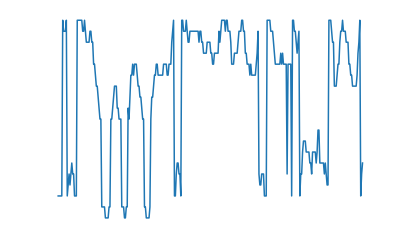

In [101]:
# now, display the predictions
raw_inputs['dayofweek'] = raw_inputs['datetime'].dayOfWeek().asfactor()
raw_inputs['dayofmonth'] = raw_inputs['datetime'].day().asfactor()
raw_inputs['hourofday'] = raw_inputs['datetime'].hour().asfactor()
raw_inputs['year'] = raw_inputs['datetime'].year().asfactor()
raw_inputs['month'] = raw_inputs['datetime'].month().asfactor()

table_with_predictions = preprocessed_inputs.concat(raw_inputs, preds)
table_with_predictions.show()


table = np.transpose(np.array(table_with_predictions.as_data_frame(use_pandas=False, header=False)))
y = table[13] # predictions
table2 = np.transpose(np.array(raw_inputs.as_data_frame(use_pandas=False, header=False)))
x = table2[0]


# plot first 2 weeks of predictions
plt.plot(x[0:336], y[0:336])
plt.axis('off')
plt.show()
